In [1]:
#### Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
from scipy.sparse import csr_matrix as smatrix
import scipy.sparse.linalg as splinalg
import os
import sys
import fem


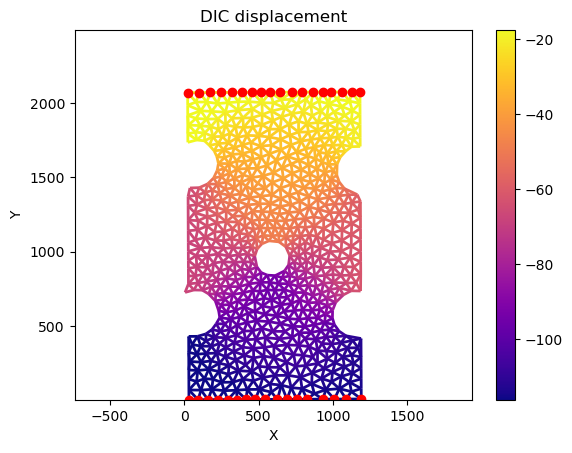

In [2]:
# Units m->pixel=m/pix2m
# Pa=kg/m/s^2->kg/pixel/s^2=Pa*pix2m
# N = kg.m/s^2->kg.pixel/s^2=N/pix2m
# N/m = kg/s^2->kg/s^2=N/m
Ns=10
pix2m=25.e-6; # pixel to m conversion
thickness=3e-3 # speimen thicness in m
stdu=0.01

inp='dic-coarse.res'
(X,conn)=fem.readDICmesh(inp)
model=fem.FEModel()
model.X=X
model.conn=conn
model.Assemble()
W=model.W
B=model.B
Kini=.5e8
Eoini=0.05
mat=fem.MatModel(pix2m)
mat.K=Kini
mat.Eo=Eoini
model.material=mat

Uref=fem.readDICDisp(inp)
Fres=(40)/thickness

Xg=0.5*(X[conn[:,0]]+X[conn[:,1]])
Nnodes=X.shape[0]
Nelems=conn.shape[0]
top=X[:,1]>max(X[:,1])*0.99
bot=X[:,1]<max(X[:,1])*0.01

fig, ax = plt.subplots()
model.show_field(fig, ax,Uref[Nnodes::], name = "DIC displacement")

plt.plot(X[top,0],X[top,1].T,'ro');
plt.plot(X[bot,0],X[bot,1].T,'ro');



In [3]:
nodes_index=np.arange(Nnodes)
top_nodes=nodes_index[top]
bot_nodes=nodes_index[bot]
const_ddls_f=np.r_[top_nodes,bot_nodes,bot_nodes+Nnodes]
const_ddls_u=np.r_[top_nodes,top_nodes+Nnodes,bot_nodes,bot_nodes+Nnodes]


Fext=np.zeros(2*Nnodes)
Uimp=np.zeros(2*Nnodes)
Uimp=Uref.copy()
U=np.zeros(2*Nnodes)

Fint=model.Solve(Ns,const_ddls_u,Uimp,Fext,U,True)
print(Fres/sum(Fint[top_nodes+Nnodes]))
scal=Fres/sum(Fint[top_nodes+Nnodes])
Fext[top_nodes+Nnodes]=Fint[top_nodes+Nnodes]*scal
print(Fres/sum(Fext[top_nodes+Nnodes]))

test=model.Solve(1,const_ddls_f,Uimp,Fext,U,True);
print('Scaling reaction', Fres/sum(test[top_nodes+Nnodes]))
Uini=U.copy()






Solving...
For load factor 0.100 after 10 iterations R/Fext = 1.000e+00 dU/U=7.287e-08
For load factor 0.200 after 11 iterations R/Fext = 1.000e+00 dU/U=1.924e-07
For load factor 0.300 after 12 iterations R/Fext = 1.000e+00 dU/U=3.799e-07
For load factor 0.400 after 13 iterations R/Fext = 1.000e+00 dU/U=7.411e-07
For load factor 0.500 after 15 iterations R/Fext = 1.000e+00 dU/U=8.003e-07
For load factor 0.600 after 18 iterations R/Fext = 1.000e+00 dU/U=7.534e-07
For load factor 0.700 after 21 iterations R/Fext = 1.000e+00 dU/U=9.554e-07
For load factor 0.800 after 26 iterations R/Fext = 1.000e+00 dU/U=8.828e-07
For load factor 0.900 after 32 iterations R/Fext = 1.000e+00 dU/U=8.695e-07
For load factor 1.000 after 38 iterations R/Fext = 1.000e+00 dU/U=9.731e-07
1.0243874649672944
1.0

Solving...
For load factor 1.000 after 40 iterations R/Fext = 1.000e+00 dU/U=9.812e-07
Scaling reaction 1.0000000008072778


In [4]:
def updatematerial(P):
    mat=fem.MatModel(pix2m)
    mat.K=Kini*P[0]
    mat.Eo=Eoini*P[1]
    return mat

def sensitivity(P,U):
    dudp = np.zeros((U.shape[0],P.size))
    dP=0.01
    mati=model.material
    Umod=U.copy();

    for ii in range(len(P)):
        Pi=P+0.;
        Pi[ii]=Pi[ii]+dP
        newmat=updatematerial(Pi)
        model.material=newmat
        model.Solve(1,const_ddls_f,Uimp,Fext,Umod,False);
        dudp[:,ii]=(Umod-U)/dP
    model.material=mati
    return dudp

def covariance(dudp):
    C = np.zeros((np.size(dudp,1),np.size(dudp,1)))
    for ii in range(np.size(dudp,1)):
        for jj in range(np.size(dudp,1)):
                C[ii][jj]=np.dot(dudp[:,ii],dudp[:,jj])
    return C


def residual(dudp,r):
    b = np.zeros((np.size(dudp,1)))
    for ii in range(np.size(dudp,1)):
                b[ii]=np.dot(dudp[:,ii],r)
    return b

P=np.array((1.,1.))
nIter=15 # number of iteration to perform
for iter in range(nIter):
    # a. compute the sensitivity matrix $dudp$ 
    dudp=sensitivity(P, U)
    # b. compute the covariance matrix $C$
    C=covariance(dudp)    
    # c. compute the residual vector $b$
    b=residual(dudp, Uref-U)
    # d. solve the system $C\; dP=b$ for getting the parameter increment
    dP=np.linalg.solve(C,b)
    # e. update the parameter values $P=P+dP$
    P+=.5*dP
    # f. update the FE solution $U$ with the updated parameters
    material=updatematerial(P)
    model.material=material
    Fint=model.Solve(1,const_ddls_u,Uimp,Fext,U,False);
    scal=Fres/sum(Fint[top_nodes+Nnodes])
    Fext[top_nodes+Nnodes]=Fint[top_nodes+Nnodes]*scal
    Fint=model.Solve(1,const_ddls_f,Uimp,Fext,U,False);

    # g. compute the norm of the gap between $U$ and $U_{DIC}$
    norm = np.linalg.norm(Uref-U)
    normp = np.linalg.norm(dP)/np.linalg.norm(P)
    print('***FEMU loop Iteration %02d: |U-Uref| =%6.3e  dP/P =%6.4f***' % (iter,norm,normp))

np.savez('femu-from-dic',U=U,mat=model.material)


***FEMU loop Iteration 00: |U-Uref| =1.256e+02  dP/P =0.1833***
***FEMU loop Iteration 01: |U-Uref| =1.243e+02  dP/P =0.0982***
***FEMU loop Iteration 02: |U-Uref| =1.237e+02  dP/P =0.0597***
***FEMU loop Iteration 03: |U-Uref| =1.235e+02  dP/P =0.0389***
***FEMU loop Iteration 04: |U-Uref| =1.233e+02  dP/P =0.0265***
***FEMU loop Iteration 05: |U-Uref| =1.233e+02  dP/P =0.0174***
***FEMU loop Iteration 06: |U-Uref| =1.232e+02  dP/P =0.0118***
***FEMU loop Iteration 07: |U-Uref| =1.232e+02  dP/P =0.0084***
***FEMU loop Iteration 08: |U-Uref| =1.231e+02  dP/P =0.0055***
***FEMU loop Iteration 09: |U-Uref| =1.231e+02  dP/P =0.0042***
***FEMU loop Iteration 10: |U-Uref| =1.231e+02  dP/P =0.0028***
***FEMU loop Iteration 11: |U-Uref| =1.231e+02  dP/P =0.0022***
***FEMU loop Iteration 12: |U-Uref| =1.231e+02  dP/P =0.0012***
***FEMU loop Iteration 13: |U-Uref| =1.231e+02  dP/P =0.0008***
***FEMU loop Iteration 14: |U-Uref| =1.231e+02  dP/P =0.0006***


In [5]:

print('INITIAL PARAMETERS\n K = %5.3f MPa,Eo %5.3f' %  (Kini*1.e-6,Eoini ))
print('IDENTIFIED PARAMETERS\n K = %5.3f MPa,Eo %5.3f' %  (Kini*P[0]*1.e-6,Eoini*P[1] ))


INITIAL PARAMETERS
 K = 50.000 MPa,Eo 0.050
IDENTIFIED PARAMETERS
 K = 43.038 MPa,Eo 0.037


(<matplotlib.collections.LineCollection at 0x7e46671c77d0>,
 <matplotlib.colorbar.Colorbar at 0x7e46672cfce0>)

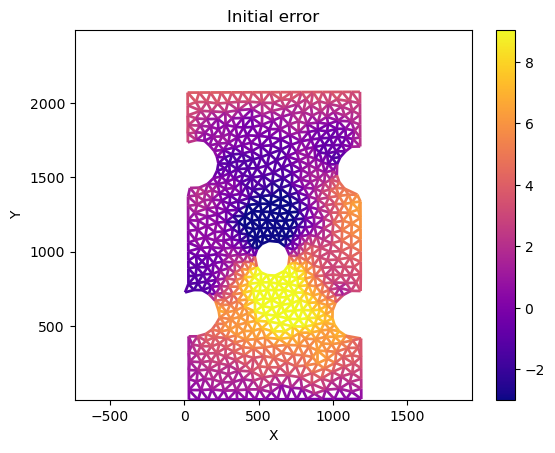

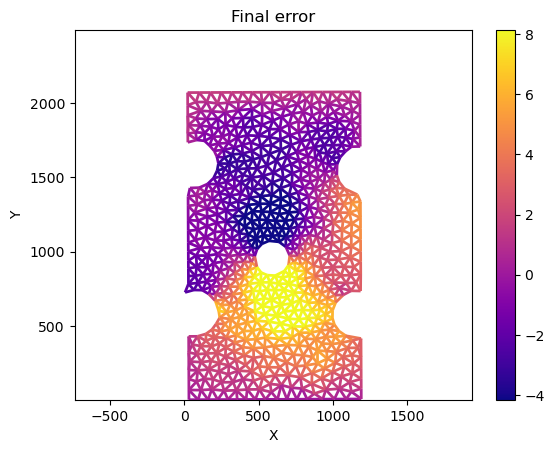

In [6]:
fig, ax = plt.subplots()
model.show_field(fig, ax,Uini[Nnodes::]-Uref[Nnodes::], name = "Initial error")
fig, ax = plt.subplots()
model.show_field(fig, ax,U[Nnodes::]-Uref[Nnodes::], name = "Final error")




[0.86076513 0.74974139]


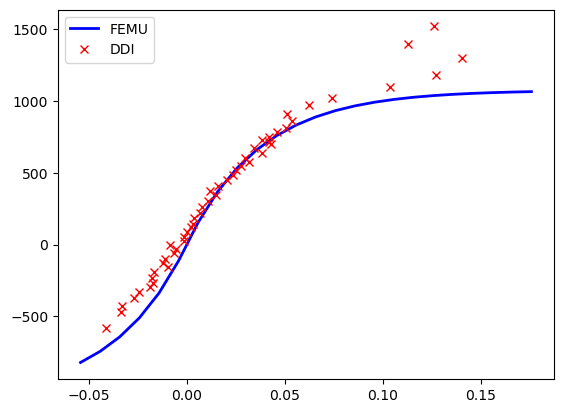

In [7]:
E=B.dot(Uref)
ddi=np.load('../DDI/ddi-from-dic.npz')
Efem=np.arange(min(E),max(E),0.01)
Sfem=material.GetStress(Efem)
ff=plt.figure()
plt.plot(Efem,Sfem,'b-', linewidth=2,label='FEMU')
plt.plot(ddi['Estar'],ddi['Sstar'],'rx',label='DDI')
plt.legend()
print(P)